In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from DataLoader.my_dataloader import get_loader
from DCNN.model import Model
import torch
import torch.nn as nn

In [2]:
PATH_1 = 'Output/DCNN_weightedLoss/best_val_evaluation_index.pkl'
PATH_2 = 'Output/DCNN_DVHLoss/best_val_evaluation_uloss.pkl'
PATH_OUT = 'Output/DCNN/output'

### Data Visualization

In [7]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(data, predicted=None):
    CT_scan = data[0][0,2]
    PTVs = data[0][0,0]
    OARs = data[0][0,1]
    Rdose = data[1][0,0]
    distance_image = data[0][0,3]
    if predicted is None: a=5 
    else: a=6
    fig, axs = plt.subplots(ncols=a, squeeze=False)
    fig.set_figwidth(20)
    fig.set_figheight(20)
    
    axs[0, 0].set_title("CT scan")
    axs[0, 0].imshow(CT_scan, cmap='gray')
    #axs[0, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    axs[0, 1].set_title("PTVs")
    axs[0, 1].imshow(PTVs, cmap='jet')

    axs[0, 2].set_title("Distance transform")
    axs[0, 2].imshow(distance_image, cmap='jet')

    axs[0, 3].set_title("OARs")
    axs[0, 3].imshow(OARs, cmap='jet')

    axs[0, 4].set_title("Radiation dose")
    axs[0, 4].imshow(Rdose, cmap='jet')

    

    if predicted is not None:
        axs[0, 5].set_title("predicted Radiation dose")
        axs[0, 5].imshow(predicted, cmap='jet')
    plt.show()



In [4]:
train, val, test = get_loader(train_bs=32,
        val_bs=1,
        test_bs=1,
        train_num_samples_per_epoch=7800,  # 5000 iterations per epoch
        val_num_samples_per_epoch=1200,
        test_num_samples_per_epoch=1200,
        num_works=1
    )
val_dataset = val.dataset

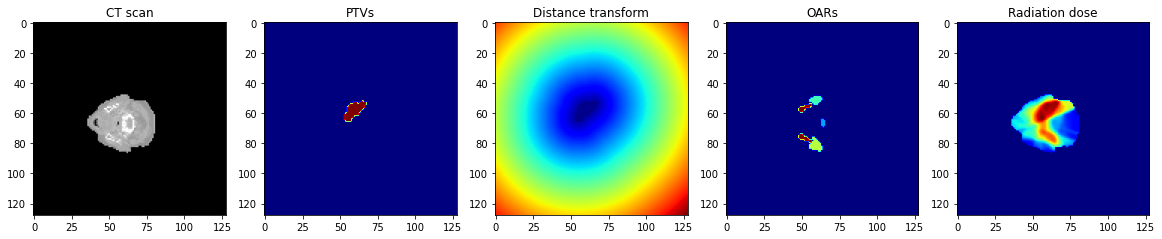

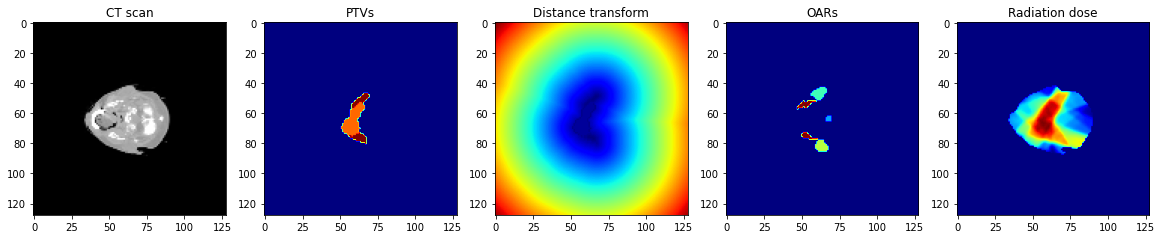

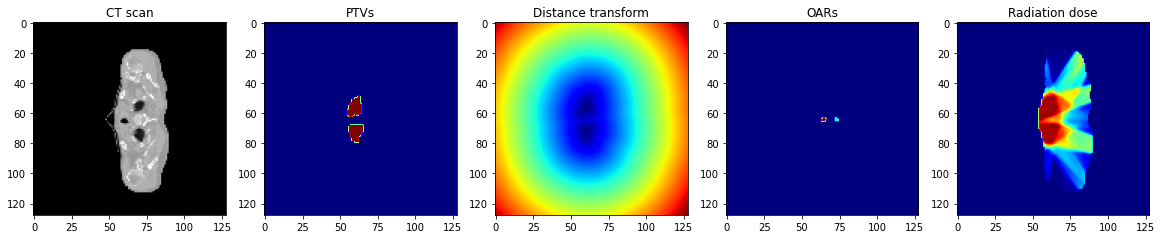

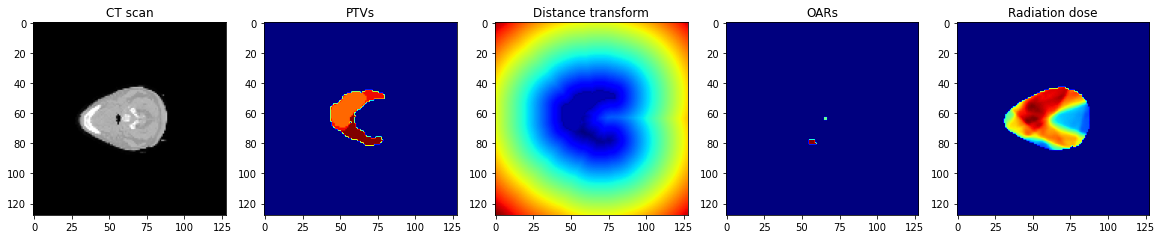

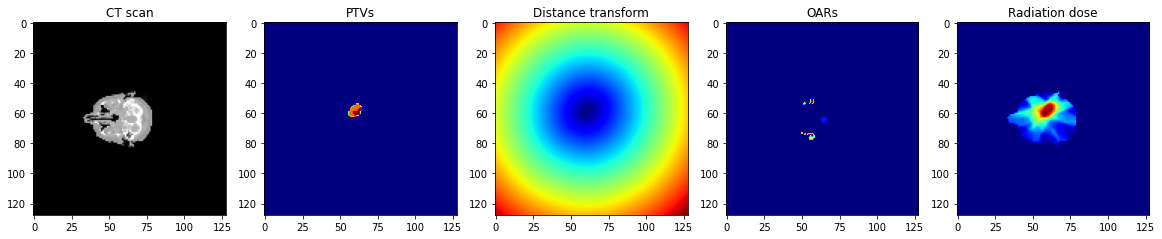

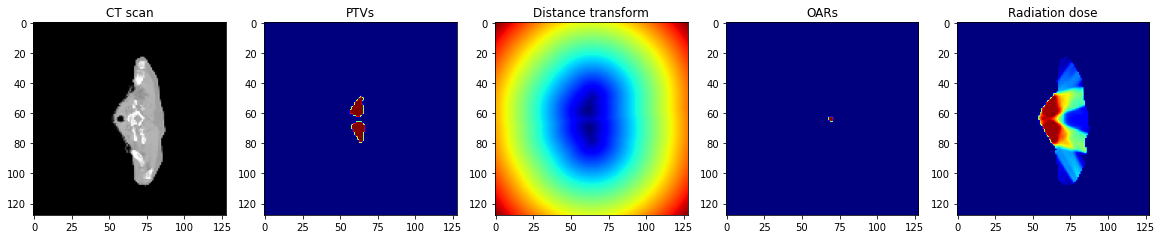

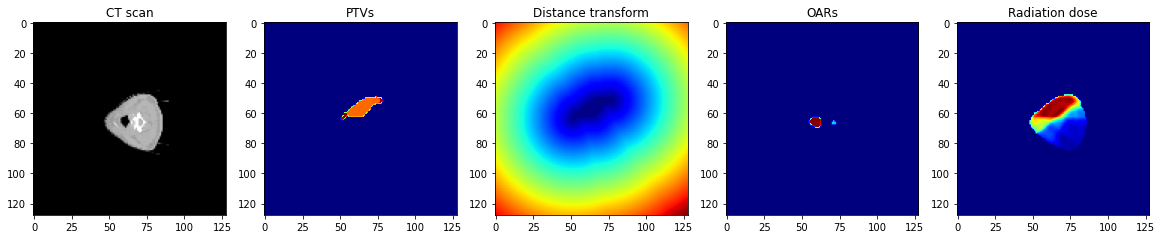

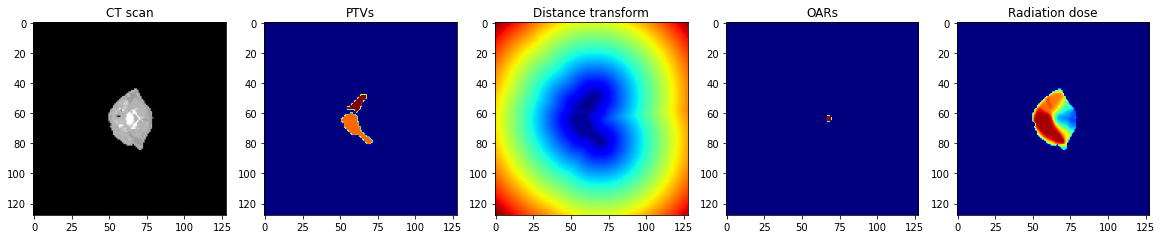

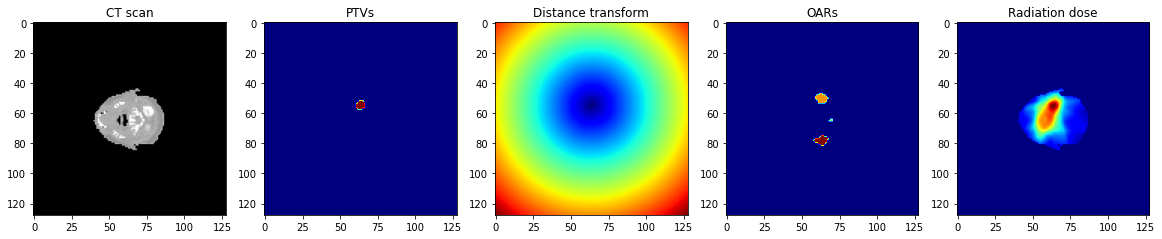

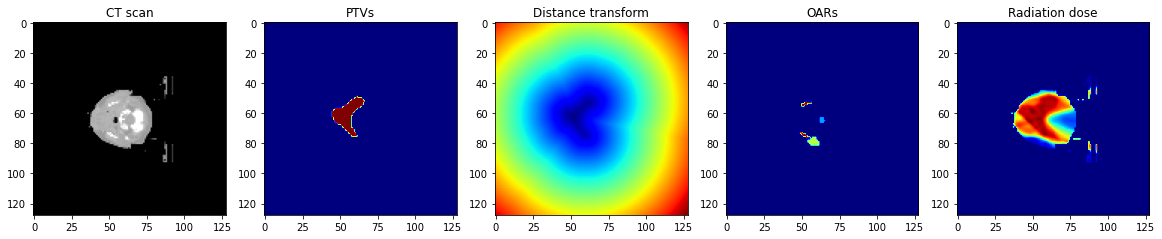

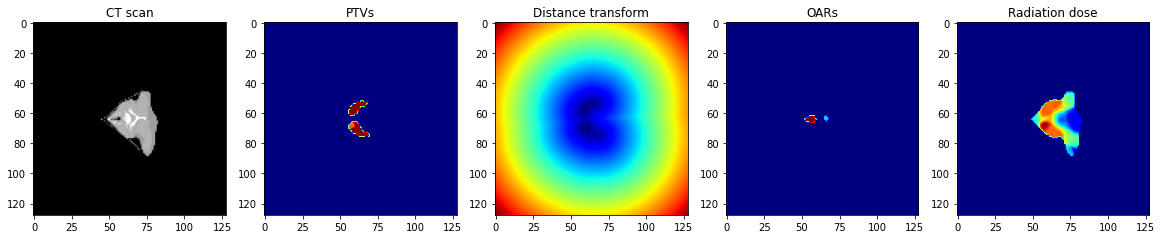

In [8]:
for batch_idx, list_loader_output in enumerate(val):
    show(list_loader_output[0]['data'])
    if batch_idx==10: break

### Test the trained models

In [5]:
model1 = Model(in_ch=4, out_ch=1,list_ch=[-1, 32, 64, 128, 256])
model1.load_state_dict(torch.load(PATH_1)['network_state_dict'])
model1 = model1.eval()

model2 = Model(in_ch=4, out_ch=1,list_ch=[-1, 32, 64, 128, 256])
model2.load_state_dict(torch.load(PATH_2)['network_state_dict'])
model2 = model2.eval()

# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !


In [46]:
#val (102, 1044)
#Test (99, 1054)
#Train (746, 6791)

### Validation

0it [00:00, ?it/s]

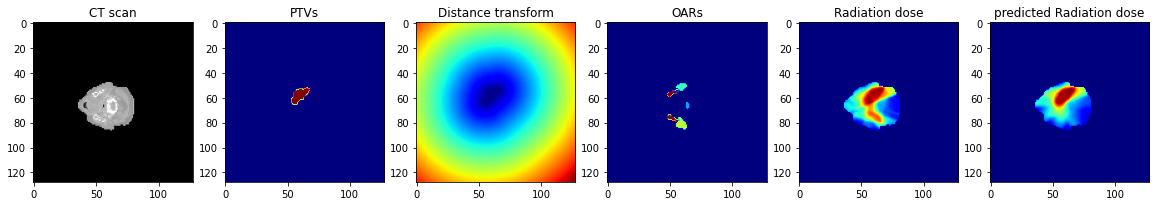

1it [00:00,  1.52it/s]

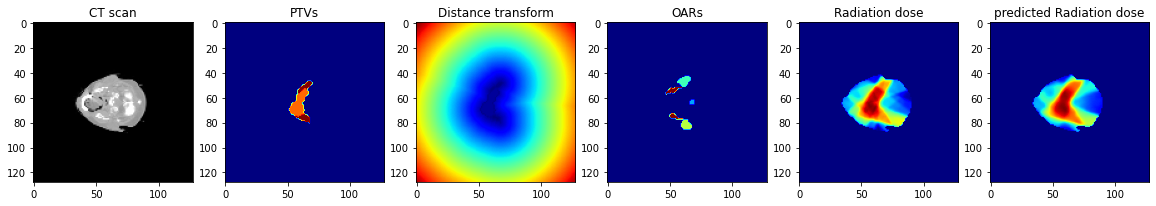

2it [00:01,  1.47it/s]

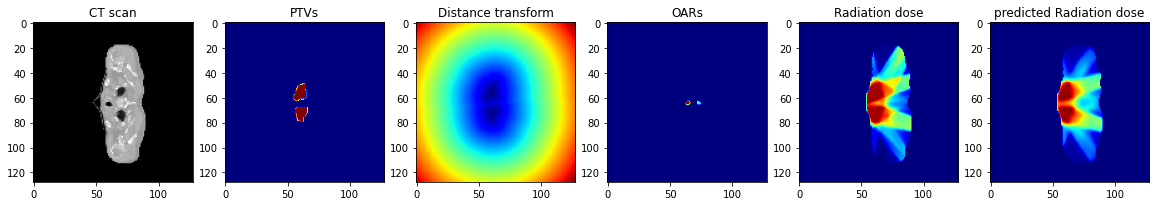

3it [00:01,  1.75it/s]

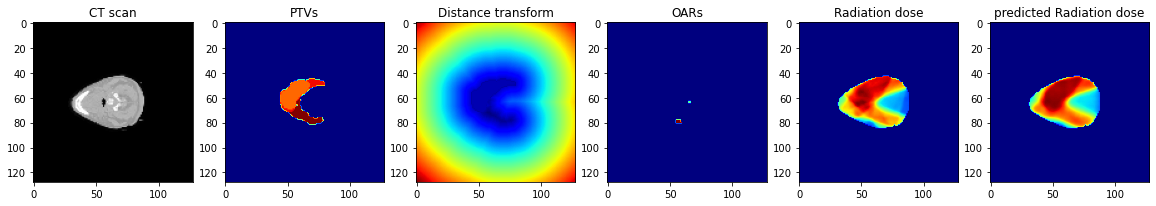

4it [00:02,  2.00it/s]

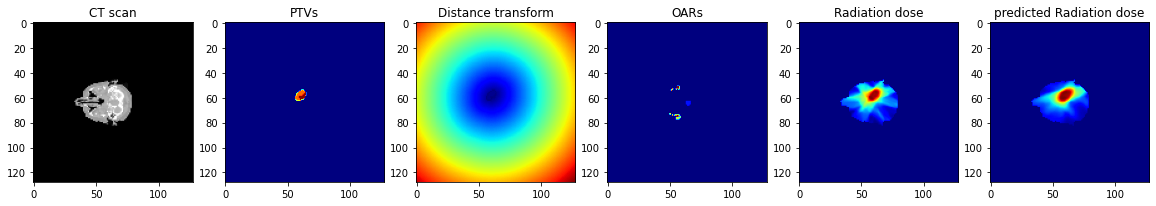

5it [00:02,  2.17it/s]

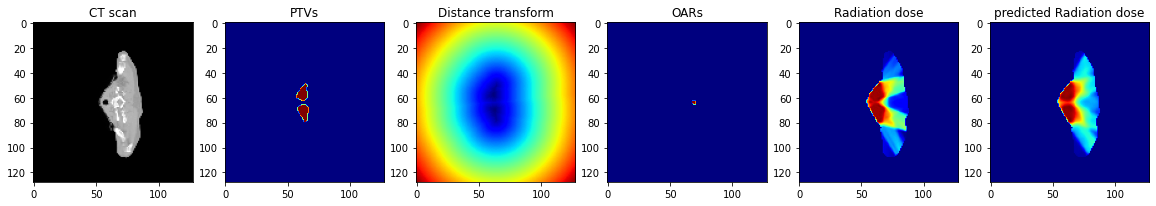

6it [00:02,  2.29it/s]

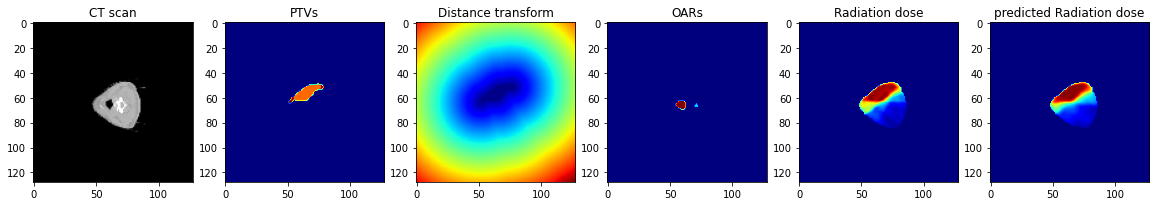

7it [00:03,  2.13it/s]

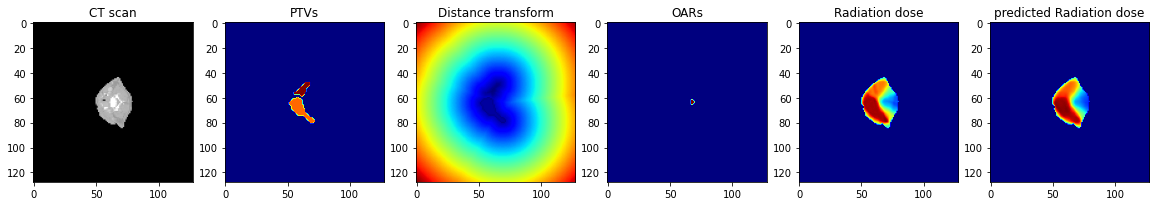

8it [00:03,  2.22it/s]

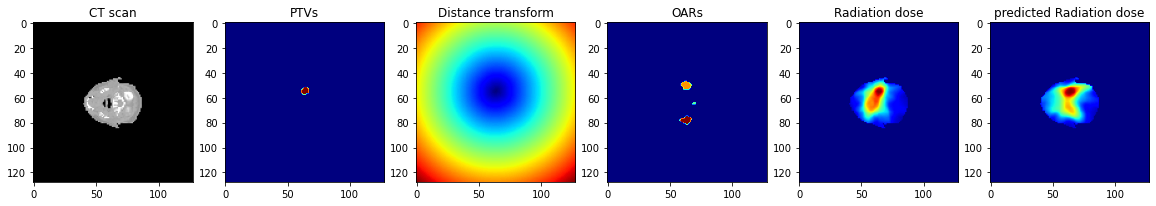

9it [00:04,  2.29it/s]

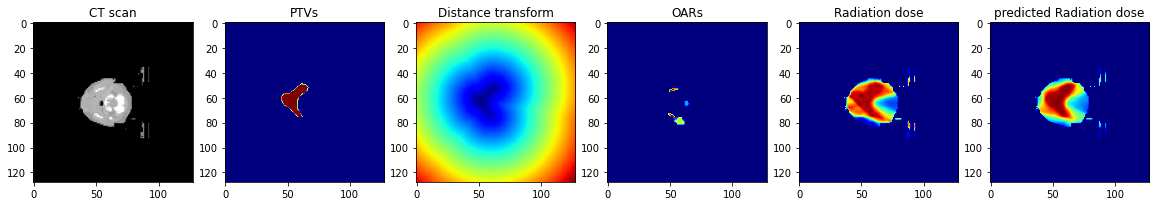

1200it [00:38, 31.51it/s]


In [9]:
from DCNN.loss import Loss, L1Loss

loss = []
Visualize = True

loss_fn= Loss()
for batch_idx, list_loader_output in tqdm(enumerate(val)):
    # List_loader_output[0] default as the input
    path = list_loader_output[1][0]
    input_ = list_loader_output[0]['data'][0]
    target = list_loader_output[0]['data'][1][0][0]
    mask = list_loader_output[0]['data'][2][0][0]
    
    output = model2(input_)
    loss.append(float(loss_fn(output[0][0], [target, mask])))
    if batch_idx<10 and Visualize:
        show(list_loader_output[0]['data'], output[0][0].detach()[0]*mask)
    
    

In [14]:
print(f'MAE of the predicted radiation dose in the validation set: %.3f' %np.mean(loss))

MAE of the predicted radiation dose in the validation set: 0.386


### Testing

In [9]:
loss = []
loss_fn= nn.L1Loss(reduction='mean')

for batch_idx, list_loader_output in tqdm(enumerate(test)):
    path = list_loader_output[1][0]
    input_ = list_loader_output[0][0]
    target = list_loader_output[0][1][0,0]
    mask = list_loader_output[0][2][0][0]

    output = model2(input_)
    img_pred = (output[0][0,0]*mask).detach().numpy()*70
    np.save(PATH_OUT + '/' + path.split('/')[-1], img_pred)        

1200it [01:24, 14.12it/s]
